In [1]:
%matplotlib notebook

In [2]:
from itertools import repeat

import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pylab as plt

from pyrsss.kalman.kalman_filter import extended_kalman_filter

In [3]:
n = np.arange(0, 101)

In [4]:
var_u = 0.0001;
std_u = np.sqrt(var_u)
delta = 1;

var_R = 0.1
var_beta = 0.01

std_R = np.sqrt(var_R)
std_beta = np.sqrt(var_beta)

In [5]:
rx_no_u = 10 - 0.2*n
ry_no_u = -5 + 0.2*n

In [6]:
x0 = np.array([10, -5, -0.2, 0.2])

In [7]:
A = sp.linalg.toeplitz([1, 0, 0, 0], r=[1, 0, delta, 0])

In [8]:
A

array([[1, 0, 1, 0],
       [0, 1, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

In [9]:
Q = np.diag([0, 0, var_u, var_u])
Q_sqrt = np.diag([0, 0, std_u, std_u])

In [10]:
R = np.diag([var_R, var_beta])
R_sqrt = np.diag([std_R, std_beta])

In [11]:
def H(x):
    h1 = np.hypot(x[0], x[1])
    h2 = np.arctan2(x[1], x[0])
    #h2 = np.arctan(x[1] / x[0])
    return np.array([h1, h2])

In [12]:
def H_jacobian(x):
    rx = x[0]
    ry = x[1]
    hypot = np.hypot(rx, ry)
    return np.array([[rx/hypot, ry/hypot, 0, 0], [-ry/hypot**2, rx/hypot**2, 0, 0]])

In [13]:
x_true = [x0]
for n_i in n[1:]:
    x_true.append(A@x_true[-1] + (Q_sqrt@np.random.randn(4, 1)).flat)

In [14]:
rx_true = [x_i[0] for x_i in x_true]
ry_true = [x_i[1] for x_i in x_true]

<IPython.core.display.Javascript object>


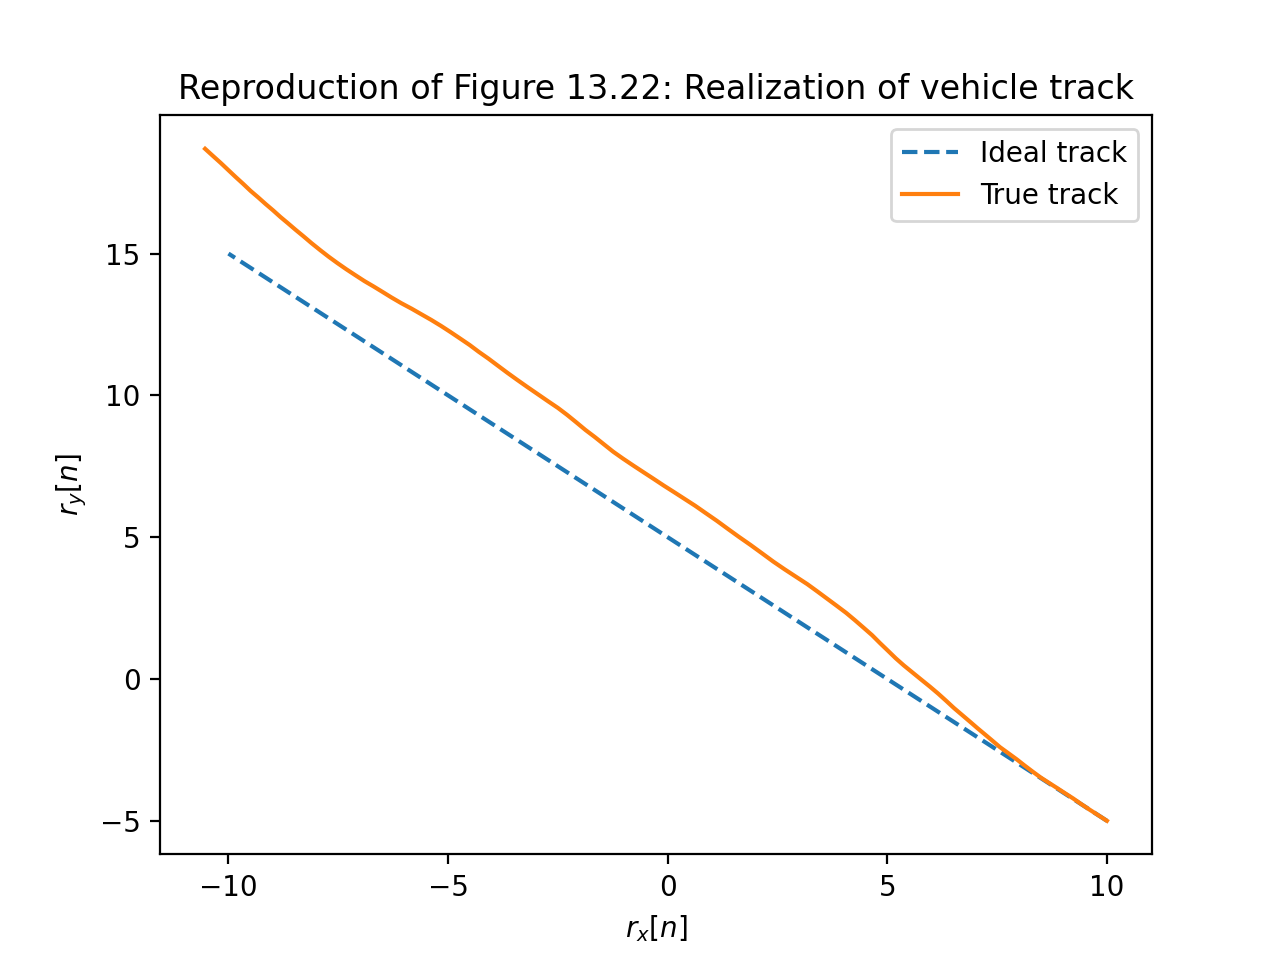

In [15]:
fig, ax = plt.subplots()
ax.plot(rx_no_u, ry_no_u, ls='--', label='Ideal track')
ax.plot(rx_true, ry_true, label='True track')
#ax.set_xlim(-15, 15)
#ax.set_ylim(-10, 20)
ax.set_title('Reproduction of Figure 13.22: Realization of vehicle track')
ax.set_xlabel(r'$r_x[n]$')
ax.set_ylabel(r'$r_y[n]$')
ax.legend();

In [16]:
y_true = list(map(H, x_true))

In [17]:
R_true = [y_i[0] for y_i in y_true]
beta_true = np.rad2deg([y_i[1] for y_i in y_true])

<IPython.core.display.Javascript object>


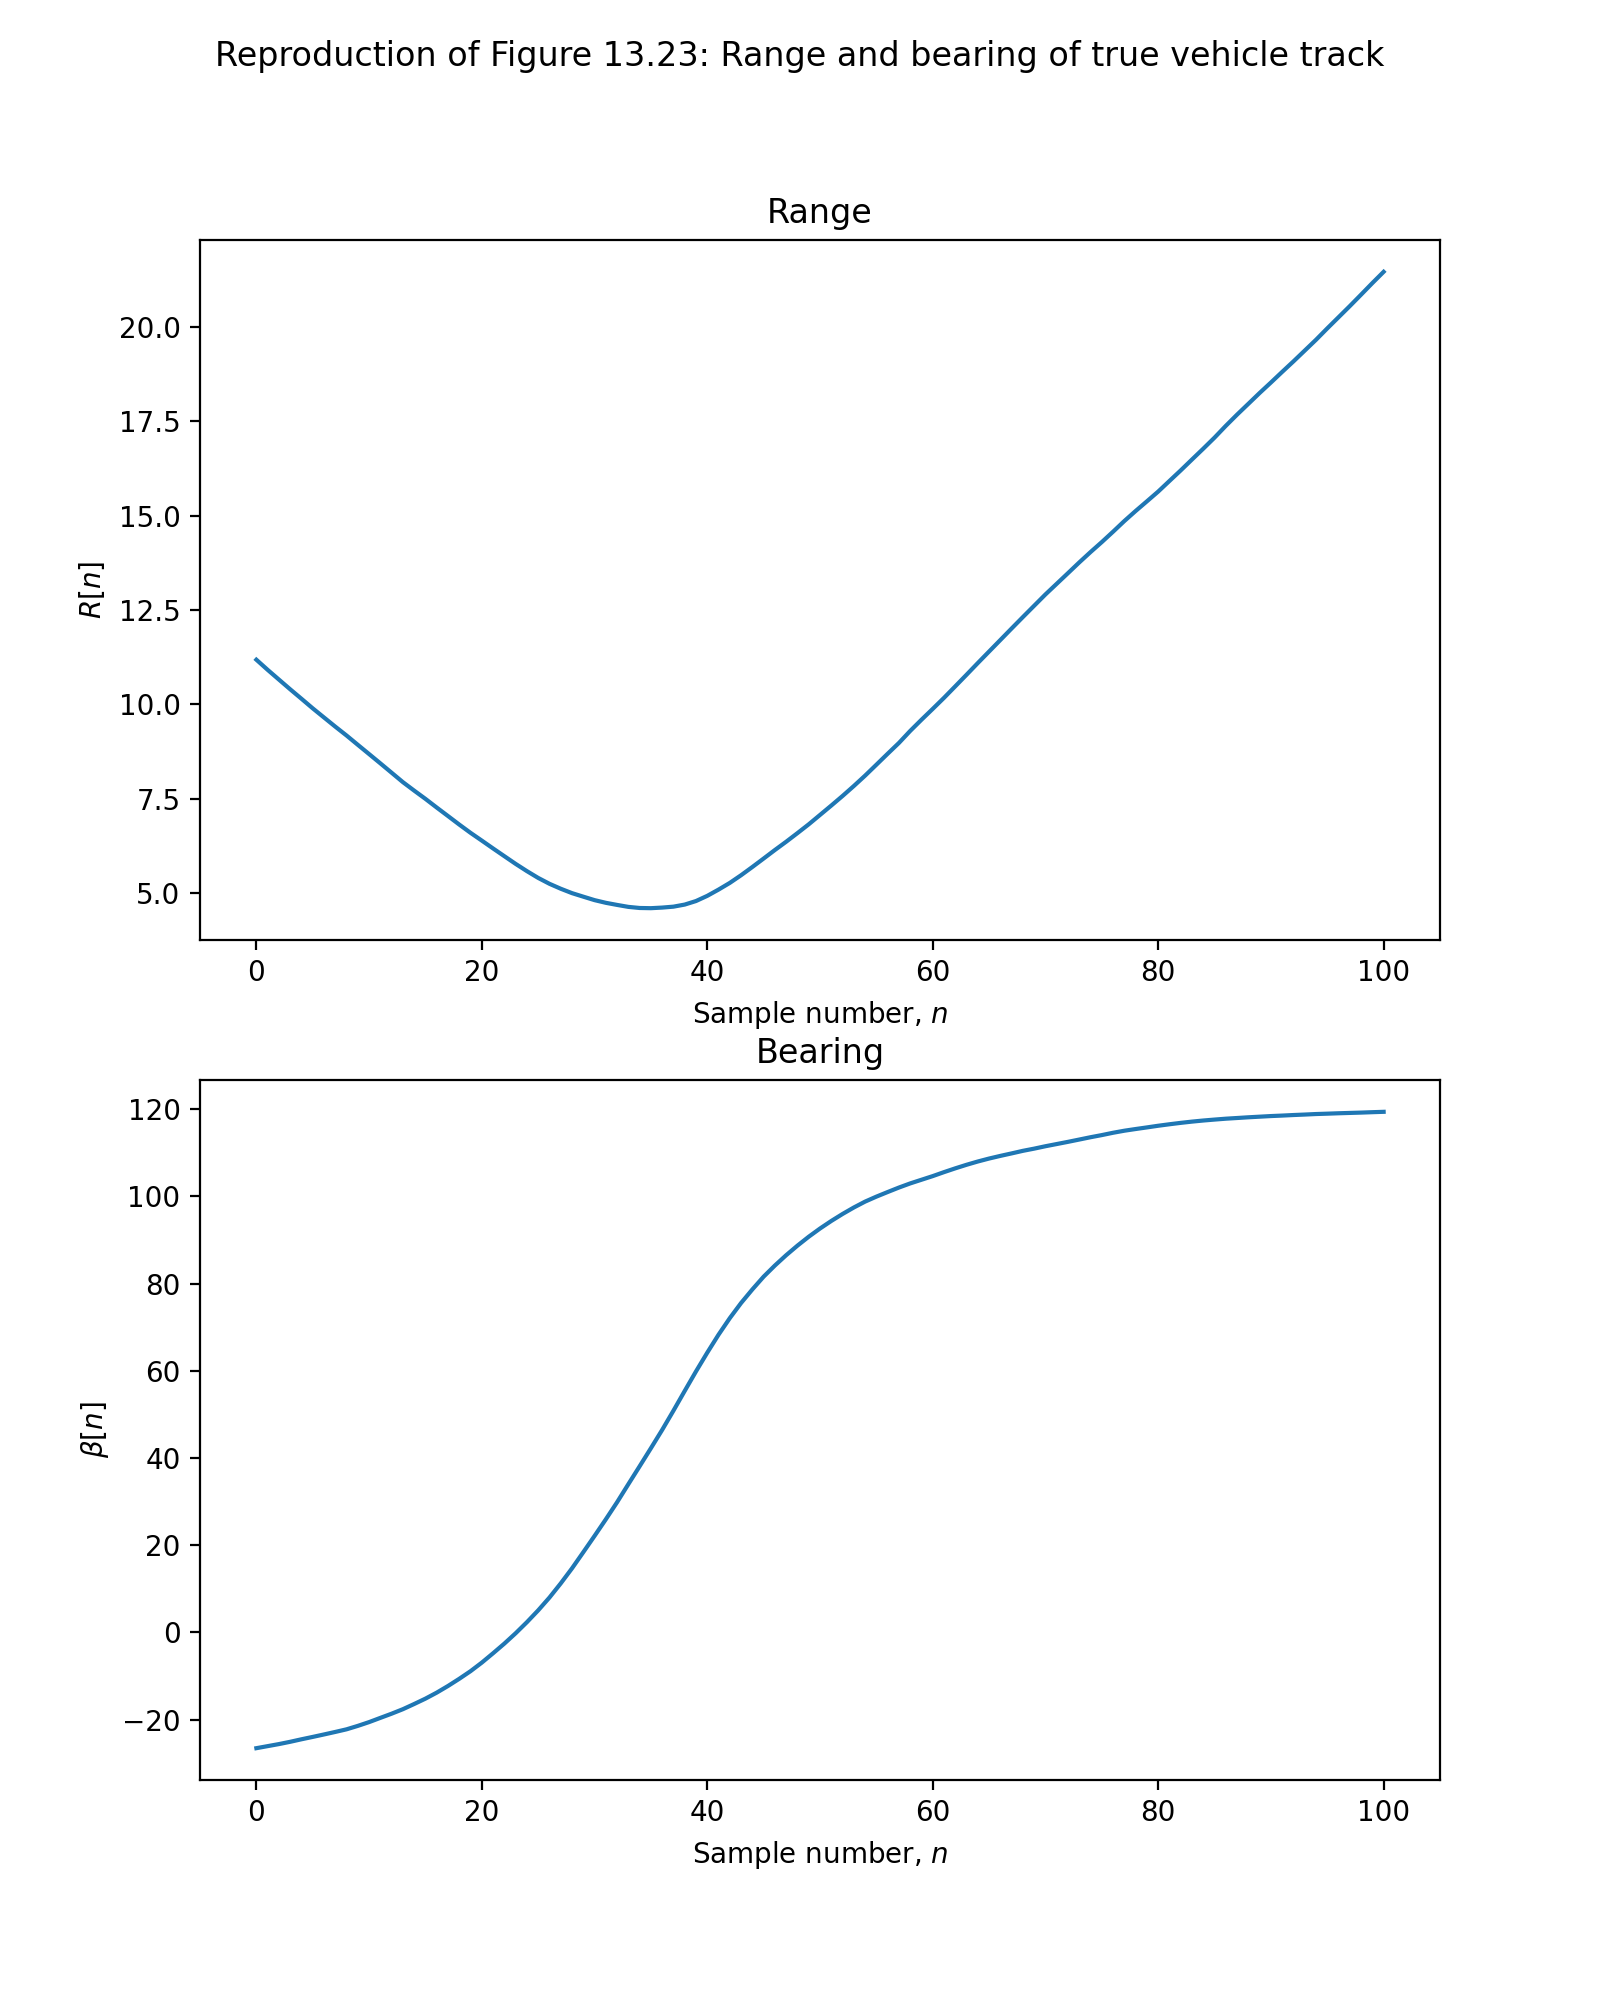

In [18]:
fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
ax[0].plot(n, R_true)
ax[0].set_xlabel(r'Sample number, $n$')
ax[0].set_ylabel(r'$R[n]$')
ax[0].set_title('Range')
ax[1].plot(n, beta_true)
ax[1].set_xlabel(r'Sample number, $n$')
ax[1].set_ylabel(r'$\beta[n]$')
ax[1].set_title('Bearing')
fig.suptitle('Reproduction of Figure 13.23: Range and bearing of true vehicle track');

In [19]:
y = [y_i + (R_sqrt @ np.random.randn(2, 1)).flat for y_i in y_true]

In [20]:
rx_obs = [R_i*np.cos(beta_i) for R_i, beta_i in y]
ry_obs = [R_i*np.sin(beta_i) for R_i, beta_i in y]

<IPython.core.display.Javascript object>


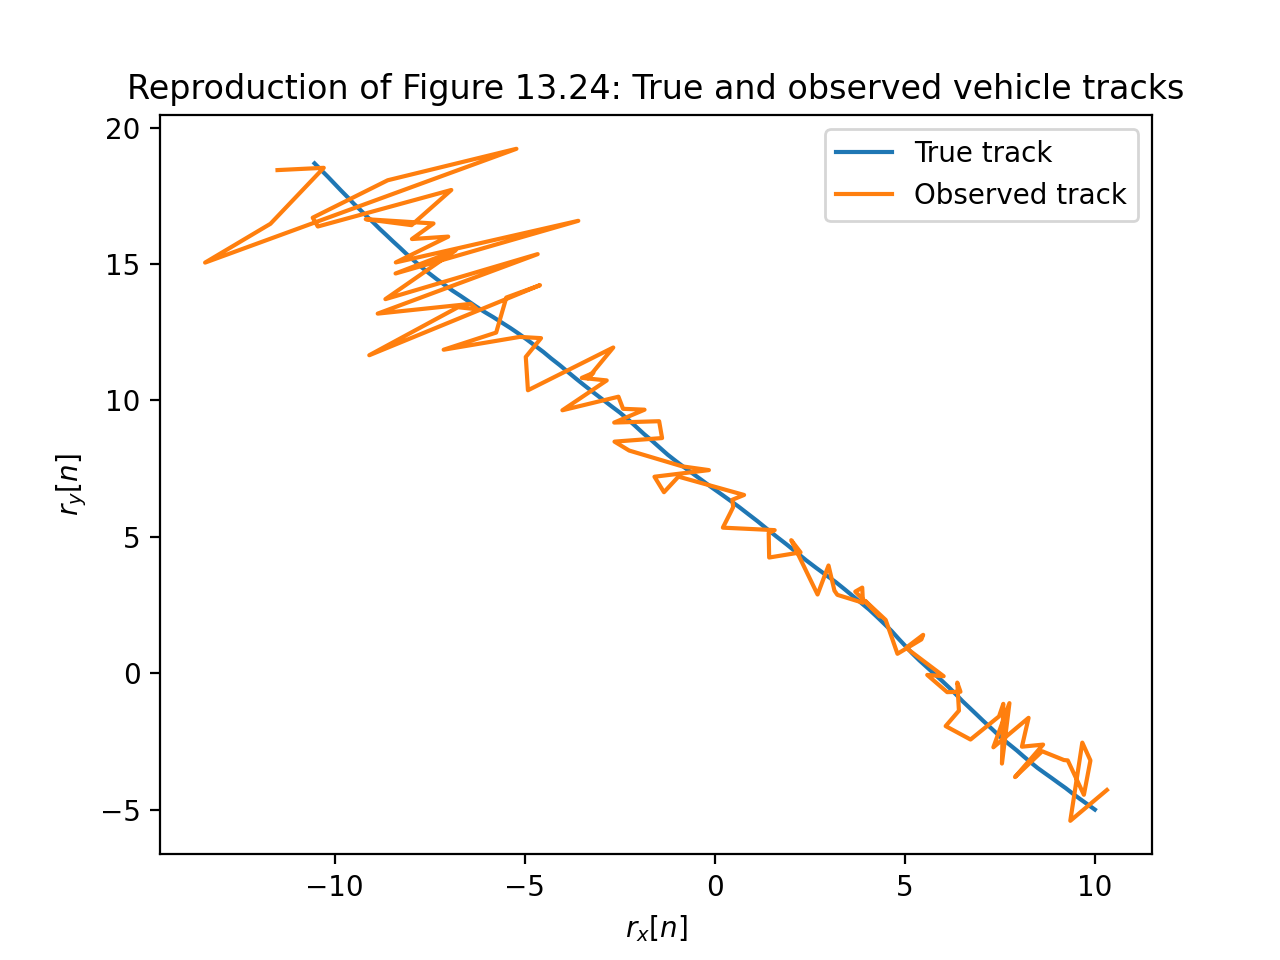

In [21]:
fig, ax = plt.subplots()
ax.plot(rx_true, ry_true, label='True track')
ax.plot(rx_obs, ry_obs, label='Observed track')
ax.set_title('Reproduction of Figure 13.24: True and observed vehicle tracks')
ax.set_xlabel(r'$r_x[n]$')
ax.set_ylabel(r'$r_y[n]$')
ax.legend();

In [22]:
H_fun = lambda x: H(x)
H_jac = lambda x: H_jacobian(x)

In [23]:
F_fun = lambda x: A @ x
F_jac = lambda x: A

In [24]:
mu = np.array([5, 5, 0, 0])
PI = 100 * np.eye(4) 

# Kay's code proceeds as time update then measurement update. So, do a time update first to match his example.
mu = A @ mu
PI = A @ PI @ A.T + Q

In [25]:
result = extended_kalman_filter(y, H_fun, H_jac, repeat(R), F_fun, F_jac, repeat(Q), mu, PI)

In [26]:
rx_hat = [x_hat_i[0] for x_hat_i in result.x_hat]
ry_hat = [x_hat_i[1] for x_hat_i in result.x_hat]

<IPython.core.display.Javascript object>


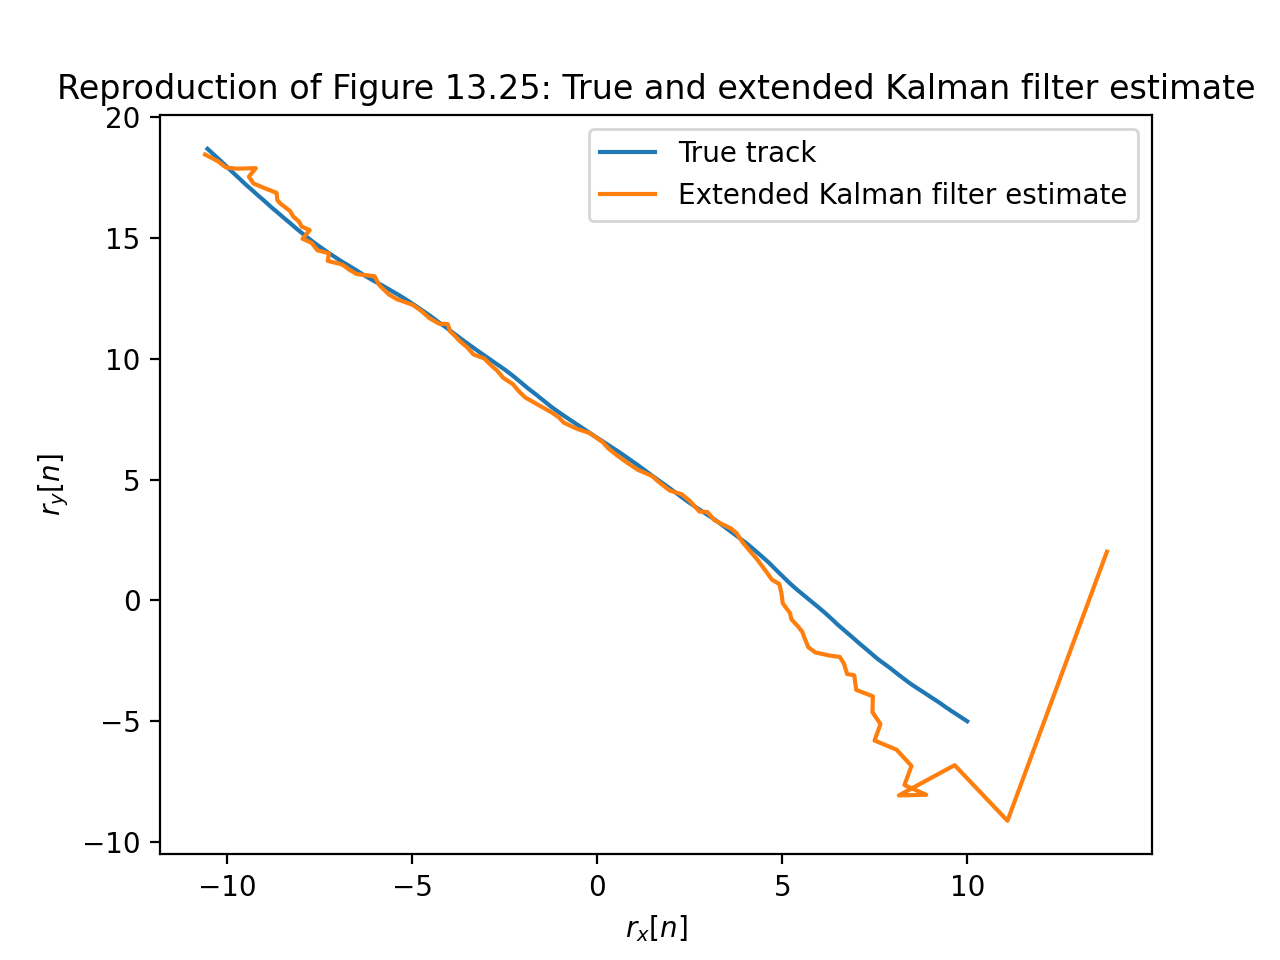

In [27]:
fig, ax = plt.subplots()
ax.plot([x[0] for x in x_true], [x[1] for x in x_true], label='True track')
ax.plot(rx_hat, ry_hat, label='Extended Kalman filter estimate')
ax.set_title('Reproduction of Figure 13.25: True and extended Kalman filter estimate')
ax.set_xlabel(r'$r_x[n]$')
ax.set_ylabel(r'$r_y[n]$')
ax.legend();